In [9]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import configparser

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

config = configparser.ConfigParser()
config.read('config.ini')

pd.options.display.max_columns=None
pd.options.display.max_rows=None
pd.options.display.max_colwidth=None

In [10]:
RAW_PATH = config['paths']['raw_data']
INTERIM_PATH = config['paths']['interim_data']
PROCESSED_PATH = config['paths']['processed_data']

In [11]:
df_all_feats = pd.read_csv(f'{PROCESSED_PATH}\data_all_feats.csv', delimiter=";")
print(df_all_feats.info())

df_all_feats.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155 entries, 0 to 1154
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date                          1155 non-null   object 
 1   year                          1155 non-null   int64  
 2   day_of_year                   1155 non-null   int64  
 3   week_of_year                  1155 non-null   int64  
 4   quarter                       1155 non-null   int64  
 5   month                         1155 non-null   int64  
 6   day_of_month                  1155 non-null   int64  
 7   weekday                       1155 non-null   int64  
 8   calls_lag                     1155 non-null   float64
 9   reservations_2months_advance  1155 non-null   float64
 10  total_reservations            1155 non-null   float64
 11  summer_break                  1155 non-null   float64
 12  christmas_break               1155 non-null   float64
 13  spe

,date,year,day_of_year,week_of_year,quarter,month,day_of_month,weekday,calls_lag,reservations_2months_advance,total_reservations,summer_break,christmas_break,special_day,break,calls
0,2013-01-01,2013,1,1,1,1,1,2,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2429
1,2013-01-02,2013,2,1,1,1,2,3,2429.0,0.0,0.0,0.0,1.0,0.0,1.0,3881
2,2013-01-03,2013,3,1,1,1,3,4,3881.0,0.0,0.0,0.0,0.0,0.0,0.0,3560
3,2013-01-04,2013,4,1,1,1,4,5,3560.0,0.0,0.0,0.0,0.0,0.0,0.0,3155
4,2013-01-05,2013,5,1,1,1,5,6,3155.0,0.0,0.0,0.0,0.0,0.0,0.0,1538


In [12]:
df_all_feats.columns

Index(['date', 'year', 'day_of_year', 'week_of_year', 'quarter', 'month',
       'day_of_month', 'weekday', 'calls_lag', 'reservations_2months_advance',
       'total_reservations', 'summer_break', 'christmas_break', 'special_day',
       'break', 'calls'],
      dtype='object')

In [13]:
# as baseline I will be using 2013 data to predict for 2014 and use existing 2014 for validation
df_baseline = df_all_feats.copy()

df_baseline['date'] = pd.to_datetime(df_baseline['date'])
df_baseline = df_baseline.set_index('date')

train_start_date = '2013-01-01'
train_end_date = '2013-12-31'
train_baseline = df_baseline[(df_baseline.index >= train_start_date) & (df_baseline.index <= train_end_date)]
print(train_baseline.info())

test_start_date = '2014-01-01'
test_end_date = '2014-12-31'
test_baseline = df_baseline[(df_baseline.index >= test_start_date) & (df_baseline.index <= test_end_date)]
print(train_baseline.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2013-01-01 to 2013-12-31
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          365 non-null    int64  
 1   day_of_year                   365 non-null    int64  
 2   week_of_year                  365 non-null    int64  
 3   quarter                       365 non-null    int64  
 4   month                         365 non-null    int64  
 5   day_of_month                  365 non-null    int64  
 6   weekday                       365 non-null    int64  
 7   calls_lag                     365 non-null    float64
 8   reservations_2months_advance  365 non-null    float64
 9   total_reservations            365 non-null    float64
 10  summer_break                  365 non-null    float64
 11  christmas_break               365 non-null    float64
 12  special_day                   365 non-null   

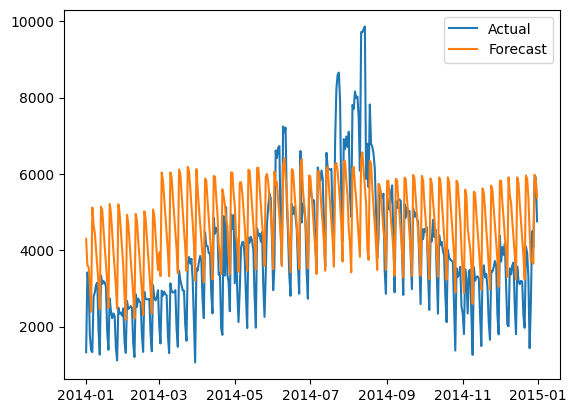

Mean Squared Error: 2326309.46
Mean Absolute Error: 1286.641


In [14]:
# all features
exogenous_vars = ['year', 'day_of_year', 'week_of_year', 'quarter', 'month', 'day_of_month', 'weekday', 'calls_lag', 'reservations_2months_advance', 'total_reservations', 'summer_break', 'christmas_break', 'special_day', 'break']

# using Arima
order = (1, 1, 1) # (p,d,q)

# use other features as exogenous variables
model_baseline = ARIMA(train_baseline['calls'], order=order, exog=train_baseline[exogenous_vars])
results = model_baseline.fit()

# forecast using the test data and exogenous variables
forecast_start_date = test_baseline.index[0]
forecast_end_date = test_baseline.index[-1]
forecast = results.predict(start=forecast_start_date, end=forecast_end_date, exog=test_baseline[exogenous_vars], dynamic=False)

plt.plot(test_baseline.index, test_baseline['calls'], label='Actual')
plt.plot(test_baseline.index, forecast, label='Forecast')
plt.legend()
plt.show()

# evaluate using mse (mean squared error)
mse = round(((forecast - test_baseline['calls']) ** 2).mean(),2)
mae = mean_absolute_error(test_baseline['calls'], forecast)

print(f'Mean Squared Error: {round(mse,3)}')
print(f'Mean Absolute Error: {round(mae,3)}')


Baseline is quite bad. Potential steps I can take to improve model:
- fine tune arima order values using Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC)
    - picks the best params based on different sets of params
- use more data points
- use only top N significant features (currently using all features)

In [15]:
def arima_model_aic_bic(train, target_column, order, exog_feats):
    model = ARIMA(train[target_column], order=order, exog=exog_feats)
    results = model.fit()
    aic = results.aic
    bic = results.bic
    return aic, bic

def arima_model(train, target_column, order, exog_feats):
    model = ARIMA(train[target_column], order=order, exog=train[exog_feats])
    results = model.fit()      
    return results

def arima_forecast(results, target_column, test, forecast_start_date, forecast_end_date, exog_feats):
    forecast = results.predict(start=forecast_start_date, end=forecast_end_date, exog=test[exog_feats], dynamic=False)
    
    plt.figure(figsize=(20, 5))
    plt.plot(test.index, test[target_column], label='Actual')
    plt.plot(test.index, forecast, label='Forecast')
    plt.legend()
    plt.show()

    mse = ((forecast - test[target_column]) ** 2).mean()
    mae = mean_absolute_error(test[target_column], forecast)

    print(f'Mean Squared Error: {round(mse,3)}')
    print(f'Mean Absolute Error: {round(mae,3)}')

In [16]:
df = df_all_feats.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

target_column = 'calls'

In [17]:
order_list = [(1, 1, 1), (2, 1, 1), (1, 1, 2)]

all_features = ['year', 'day_of_year', 'week_of_year', 'quarter', 'month', 'day_of_month', 'weekday', 'calls_lag', 'reservations_2months_advance', 'total_reservations', 'summer_break', 'christmas_break', 'special_day', 'break']
sig_features = ['year', 'day_of_year', 'week_of_year', 'quarter', 'month', 'weekday', 'calls_lag', 'summer_break', 'special_day', 'break']
top5_features = ['day_of_year', 'week_of_year', 'quarter', 'month', 'calls_lag']

exog_variables_list = [df[all_features], df[sig_features], df[top5_features]]

best_aic = np.inf
best_bic = np.inf
best_order = None
best_exog = None

for i in order_list:
    for j in exog_variables_list:
        aic, bic = arima_model_aic_bic(df, target_column, i, j)
        print(f"Order {i}, Exog {j.columns.tolist()}: AIC={round(aic,2)}, BIC={round(bic,2)}")

        if aic < best_aic:
            best_aic = aic
            best_bic = bic
            best_order = i
            best_exog = j

print(f"Best Model: Order= {best_order}, Exog Vars= {best_exog.columns.tolist()}: AIC={round(best_aic,2)}, BIC={round(best_bic)}")

Order (1, 1, 1), Exog ['year', 'day_of_year', 'week_of_year', 'quarter', 'month', 'day_of_month', 'weekday', 'calls_lag', 'reservations_2months_advance', 'total_reservations', 'summer_break', 'christmas_break', 'special_day', 'break']: AIC=18263.76, BIC=18349.62
Order (1, 1, 1), Exog ['year', 'day_of_year', 'week_of_year', 'quarter', 'month', 'weekday', 'calls_lag', 'summer_break', 'special_day', 'break']: AIC=18725.67, BIC=18791.33
Order (1, 1, 1), Exog ['day_of_year', 'week_of_year', 'quarter', 'month', 'calls_lag']: AIC=19548.14, BIC=19588.55
Order (2, 1, 1), Exog ['year', 'day_of_year', 'week_of_year', 'quarter', 'month', 'day_of_month', 'weekday', 'calls_lag', 'reservations_2months_advance', 'total_reservations', 'summer_break', 'christmas_break', 'special_day', 'break']: AIC=18261.74, BIC=18352.66
Order (2, 1, 1), Exog ['year', 'day_of_year', 'week_of_year', 'quarter', 'month', 'weekday', 'calls_lag', 'summer_break', 'special_day', 'break']: AIC=18726.89, BIC=18797.61
Order (2, 1

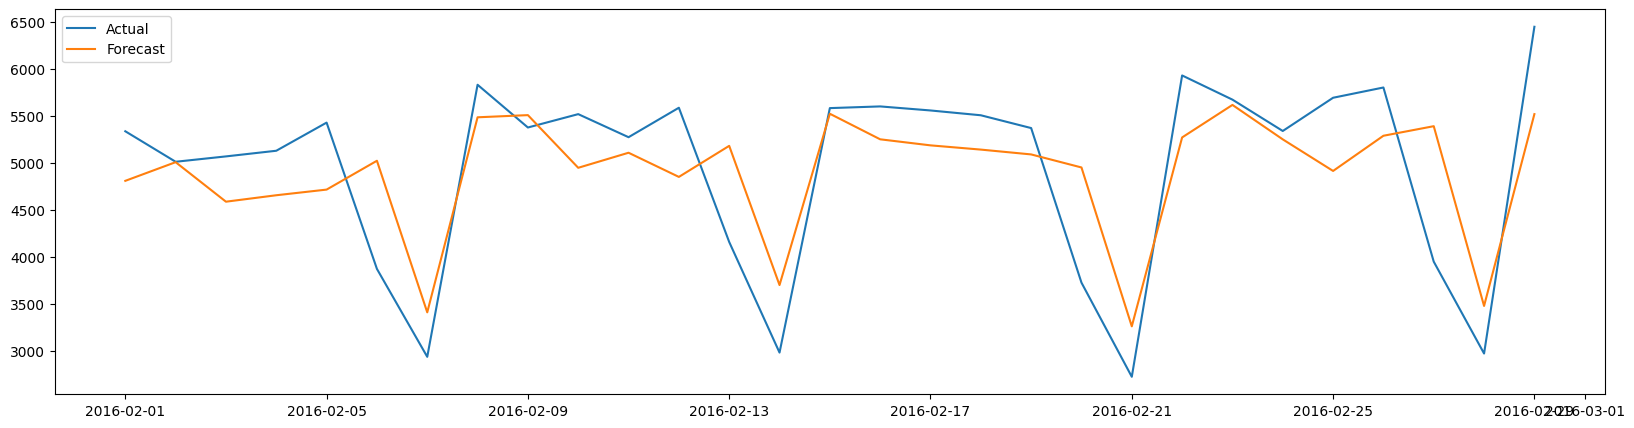

Mean Squared Error: 418092.51
Mean Absolute Error: 539.742


In [26]:
# train & forecast for 2016 data (against actual)
test_start_date = '2016-02-01'
test_end_date = '2016-02-29'
test = df[(df.index >= test_start_date) & (df.index <= test_end_date)]

results = arima_model(df, target_column, best_order, best_exog.columns.tolist())
arima_forecast(results, target_column, test, test_start_date, test_end_date, best_exog.columns.tolist())